In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from ipynb.fs.full.UtilCollections import POSITIONS
from ipynb.fs.full.UtilFunctions import format_season


In [2]:
def pre_process(seasons):
    df = None
    for season in seasons:
        first_year, second_year = format_season(season)
        player_data = pd.read_csv(f"DataCollection/Player_Stats/player_stats_{first_year}-{second_year}.csv")
        if season > 1997:
            shooting_data = pd.read_csv(f"DataCollection/Player_Shooting_Stats/Regular_Season/player_shooting_stats_{first_year}-{second_year}.csv")
            player_data = pd.merge(player_data, shooting_data.loc[:,~shooting_data.columns.isin(['Pos', 'Age', 'G', 'MP', 'FG%', "3PAr", "2P%", "3P%"])], on=['Player', 'Tm'])

        player_data = player_data.fillna(0)
        player_data = player_data[(player_data["MP"] > 15) & (player_data["G"] >= 30)]
        player_data = player_data.sort_values(by=['G'], ascending=False)
        player_data = player_data[player_data["Tm"] != "TOT"]
        player_data = player_data.drop_duplicates(subset ="Player",keep = "first")
        player_data.reset_index(inplace=True)
        player_data.drop(columns=['index'], inplace=True)
        player_data["Player"] = player_data["Player"] + " - " + str(season)
        if df is None:
            df = player_data
        else:
            df = pd.concat([df, player_data])
            
    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)
    return df

In [3]:
def process_pca(df, feature_cols):
    #Select features
    features = df[feature_cols].values
    #z-normalize
    x = StandardScaler().fit_transform(features)
    
    #reduce dimensionality
    pca = PCA(n_components=2)
    components = pca.fit_transform(x)

    componentsDf = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
    pca_df = pd.concat([componentsDf, df[['Pos', "Player"]]], axis=1)
    return pca_df

In [4]:
def plot_pca(df, target_col, targets, min_pc1=-5, min_pc2=-5, max_pc1=10, max_pc2=10):
    fig = plt.figure(figsize = (16,16))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)

    colors = [f"#{random.randrange(0x1000000):06x}"
        for i in range(len(targets))]
              
    for target, color in zip(targets,colors):
        indicesToKeep = df[target_col] == target
        ax.scatter(df.loc[indicesToKeep, 'PC1'], pca_df.loc[indicesToKeep, 'PC2'], 
                   c=color, s=50, alpha=.8)
    ax.legend(targets)
    ax.grid()

    for i, row in df.iterrows():
        if row["PC1"] < min_pc1 or row["PC2"] < min_pc2 or row["PC1"] > max_pc1 or row["PC2"] > max_pc2:
            ax.annotate(row["Player"], (row["PC1"]-3, row["PC2"]))

In [5]:
def plot_elbow_method(data, clusters_range):
    inertias = []

    for i in clusters_range:
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)

    plt.plot(clusters_range, inertias, marker='o')
    plt.title('Elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

In [6]:
def plot_silhouette_method(data, clusters_range):
    silhouette_avg = []
    for n in clusters_range: 
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(data)
        cluster_labels = kmeans.labels_
        silhouette_avg.append(silhouette_score(data, cluster_labels))

    plt.plot(clusters_range,silhouette_avg,'bx-')
    plt.grid()
    plt.yticks(np.arange(0.2, 0.6, 0.1))
    plt.xlabel('Values of K') 
    plt.ylabel('Silhouette score')
    plt.title('Silhouette analysis For Optimal k')
    plt.show()
    return silhouette_avg

In [7]:
def run_kmeans(data, clusters):
    kmeans = KMeans(n_clusters=CLUSTERS)
    kmeans.fit(data)
    cmap = plt.cm.get_cmap('Dark2', CLUSTERS)
    return kmeans.labels_, cmap

In [8]:
def plot_kmeans(df, cmap, clusters, min_pc1=-5, min_pc2=-5, max_pc1=10, max_pc2=10):
    plt.figure(figsize=(12, 12))
    plt.scatter(df["PC1"], df["PC2"], c=df['Cluster'], cmap=cmap)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    for i, row in df.iterrows():
        if row["PC1"] < min_pc1 or row["PC2"] < min_pc2 or row["PC1"] > max_pc1 or row["PC2"] > max_pc2:
            plt.text(row["PC1"]-2, row["PC2"], row["Player"])
    plt.axis('equal')
    plt.colorbar(ticks=range(clusters))
    plt.show()

In [9]:
def find_position_distribution(df, clusters):
    clustered_df = df.groupby(["Cluster", "Pos"]).count()[["Player"]]
    for i, row in clustered_df.iterrows():
        clustered_df.loc[i, "Position%"] = row['Player'] / clustered_df.loc[i[0]].sum()['Player']
    position_percentages = {}

    for p in POSITIONS:
        position_percentages[p] = []

    for i in range(clusters):
        cluster = clustered_df.loc[i]
        for p in POSITIONS:
            if p in list(cluster.index):
                position_percentages[p].append(cluster.loc[p]['Position%'])
            else:
                position_percentages[p].append(0)
    
    return position_percentages

In [10]:
def plot_position_distribution(pp, clusters, print_numbers=False, fig_name="PlayerDistribution"):
    fig, ax = plt.subplots(figsize=(20, 12), dpi=80)

    counter = np.zeros(clusters)

    for position in POSITIONS:
        ax.bar(range(clusters), pp[position], bottom=counter, label=position)
        counter += np.array(pp[position])

    if print_numbers:
        for bar in ax.patches:
            ax.text(bar.get_x() + bar.get_width()/2, 
                    bar.get_y() + (bar.get_height() * 0.45), 
                    round(bar.get_height(),2), 
                    ha='center', color='black', weight='bold', size=12)

    ax.set_xlabel("Cluster", fontsize=18)
    ax.set_ylabel("% of position in the cluster", fontsize=18)
    ax.set_xticks(range(clusters))
    ax.legend(loc='center left', bbox_to_anchor=(0.95, 0.5),
              fancybox=True, shadow=True, ncol=1, prop={'size': 15})
    plt.savefig(f"Results/Clustering/{fig_name}.jpg", bbox_inches='tight')
    plt.show()

In [11]:
def run_random_pca(df, non_feature_cols, target):
    features = df.loc[:, ~df.columns.isin(non_feature_cols)]
    random_selector = np.random.choice(a=[False, True], size=len(features.columns), p=[.5, .5])
    random_features_df = features.loc[:, random_selector]
    selected_features = list(random_features_df.columns)
    random_features = random_features_df.values        
    random_features = StandardScaler().fit_transform(random_features)
    
    if random_features.shape[1] <= 0.45 * len(features.columns):
        return None, None
    
    pca = PCA(2)
    components = pca.fit_transform(random_features)
    components_df = pd.DataFrame(data=components, columns=["PC1", "PC2"])
    components_df = pd.concat([components_df, df[target]], axis=1)
    var = pca.explained_variance_ratio_
    return components_df, [selected_features, len(selected_features), var[0], var[1], sum(var)]

In [12]:
def iterate_random_pcas(df, non_feature_cols, target, iterations, csv):
    PCAs = pd.DataFrame(columns=["Features", "Features Count", "PC1 var", "PC2 var", "Total explained variance ratio"])
    for i in range(iterations):
        pca_df, pca_stats = run_random_pca(df, non_feature_cols, target)
        if pca_df is not None:
            pca_row = {'Features': ' '.join(pca_stats[0]),
                       'Features Count': pca_stats[1],
                       'PC1 var': pca_stats[2],
                       'PC2 var': pca_stats[3],
                       'Total explained variance ratio': pca_stats[4]}
            PCAs = PCAs.append(pca_row, ignore_index=True)
    PCAs.to_csv(f"DataCollection/PCA/{csv}.csv", index=False)

## Process data and run PCA

In [13]:
df = pre_process(range(2017,2023))

In [14]:
pca_df = process_pca(df, [c for c in df.columns if c not in (["Player", "Pos", "Tm"])])

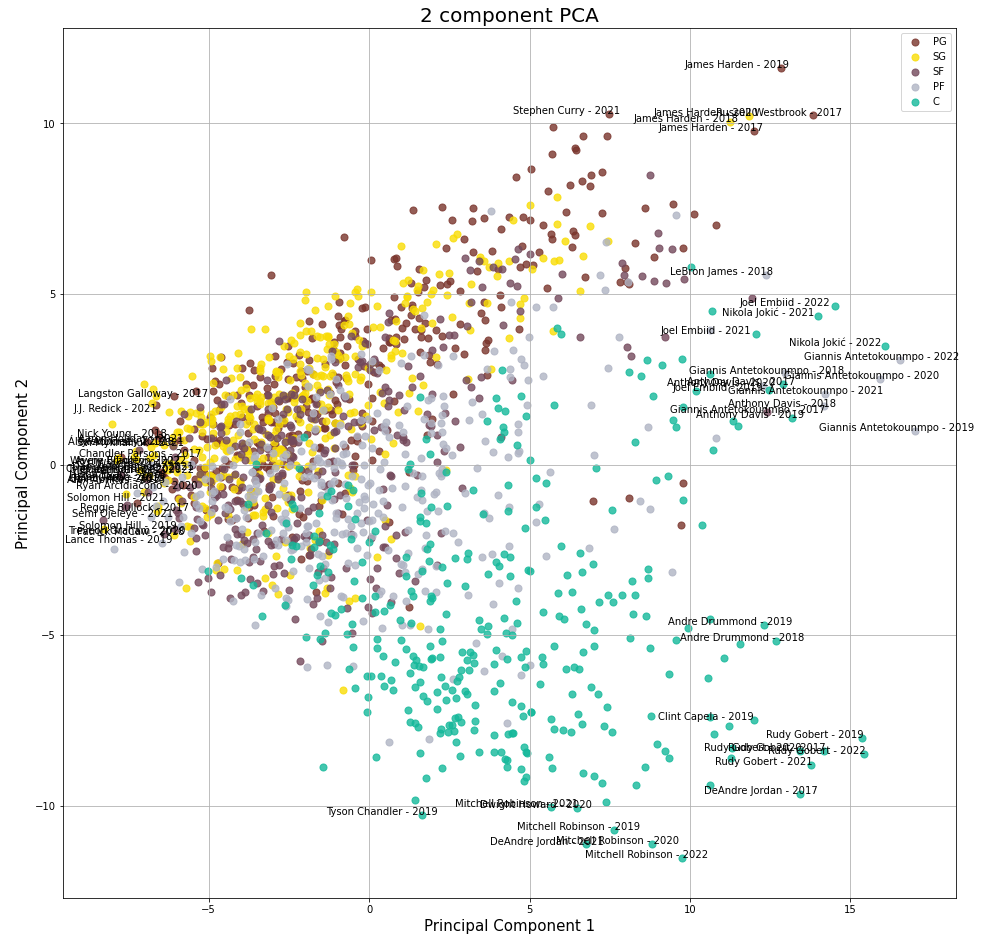

In [15]:
plot_pca(pca_df, 'Pos', ['PG', 'SG', 'SF', 'PF', 'C'], -6, -10, 12, 10)

# Clustering

In [16]:
data = list(zip(pca_df["PC1"], pca_df["PC2"]))

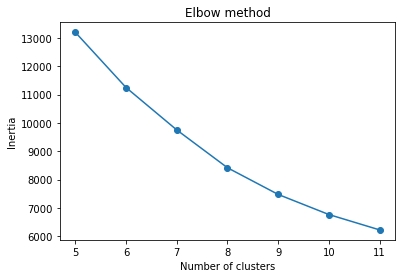

In [17]:
plot_elbow_method(data, range(5,12))

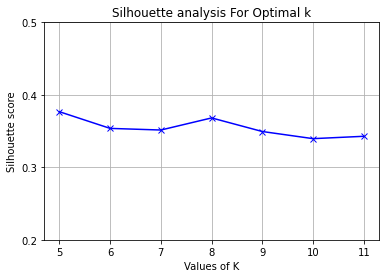

In [18]:
silhouette_avg = plot_silhouette_method(data, range(5,12))

## Run K-means

In [19]:
CLUSTERS = np.argmax(silhouette_avg)+5

In [20]:
pca_df['Cluster'], cmap = run_kmeans(data, CLUSTERS)

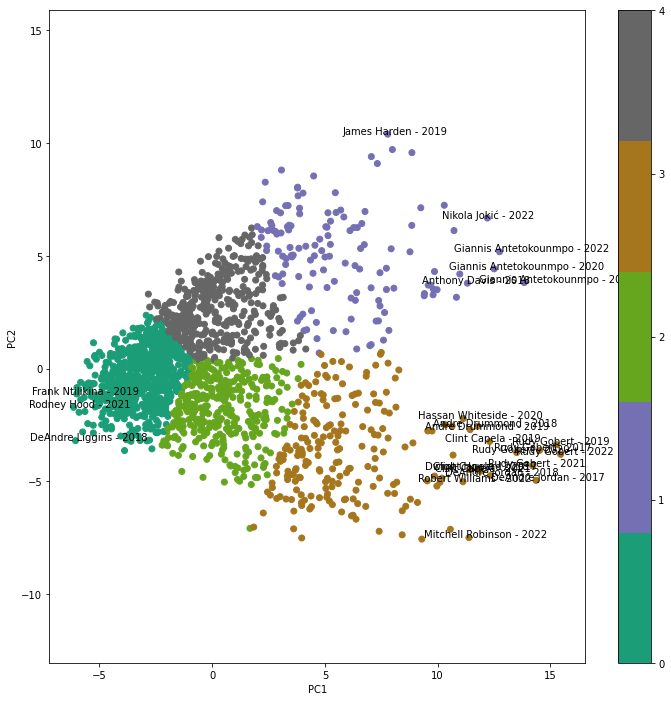

In [40]:
plot_kmeans(pca_df, cmap, CLUSTERS, -6, -12, 11, 10)

## Group by clusters, find distribution of the positions in each cluster

In [22]:
position_percentages = find_position_distribution(pca_df, CLUSTERS)

## Plot player distribution as cummulative bar charts

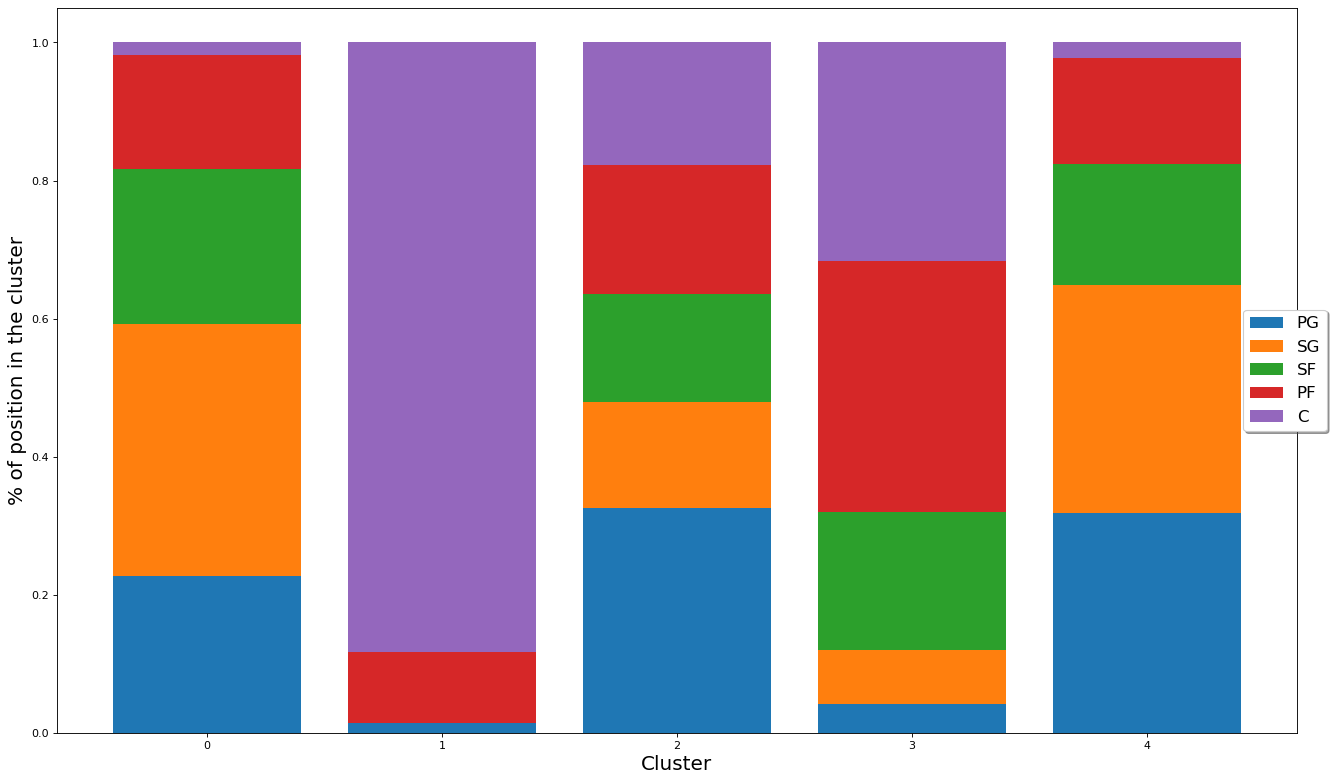

In [23]:
plot_position_distribution(position_percentages, CLUSTERS)

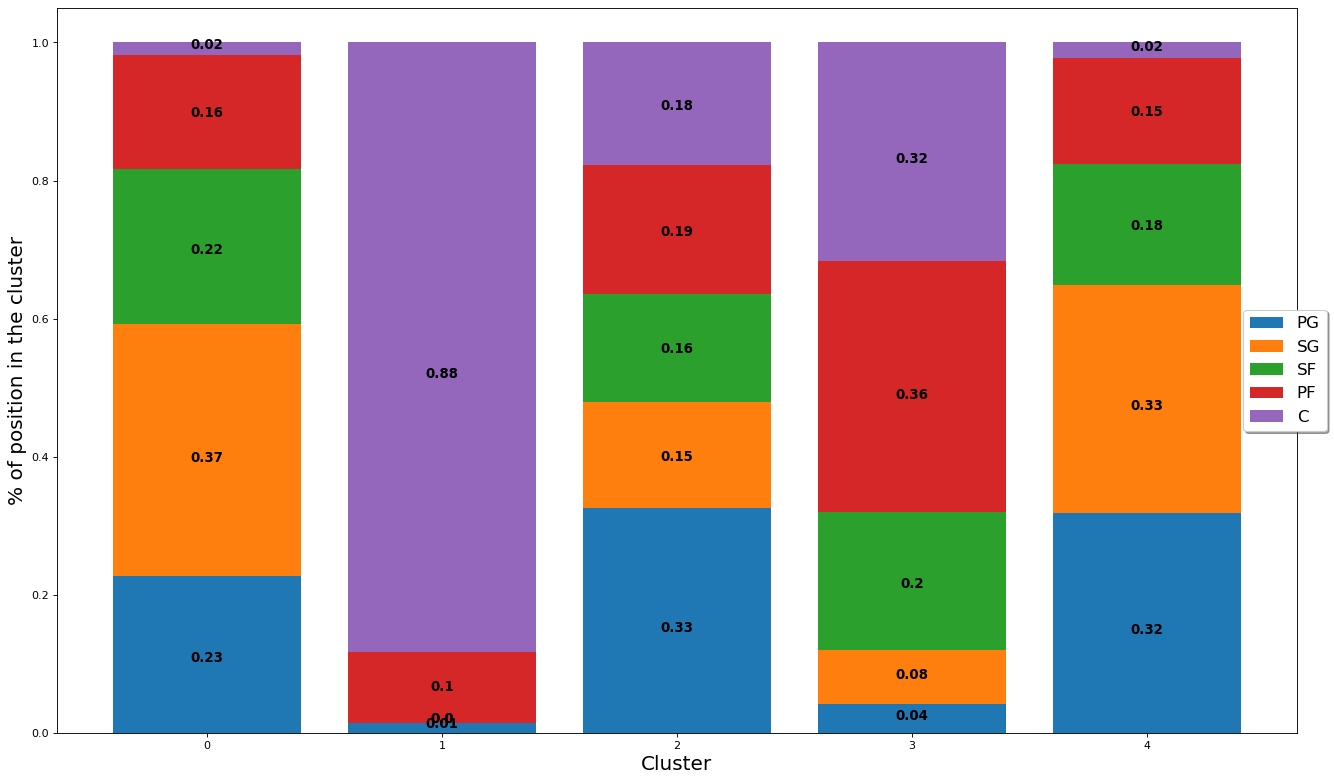

In [24]:
plot_position_distribution(position_percentages, CLUSTERS, True, "PlayerDistributionWithValues")

## Randomizing PCA features

## Run 10.000 random PCAs, find the ones with highes Explained Variance Ratio

In [25]:
iterate_random_pcas(df, ["Player", "Pos", "Tm"], ["Player", "Pos"], 10**5, "PlayerAndShooting")

In [26]:
PCAs = pd.read_csv("DataCollection/PCA/PlayerAndShooting.csv")

In [27]:
PCAs.sort_values(by='Total explained variance ratio', ascending=False, inplace=True)

In [48]:
pca_df = process_pca(df, PCAs.iloc[2]['Features'].split())

### Plot the chosen PCA

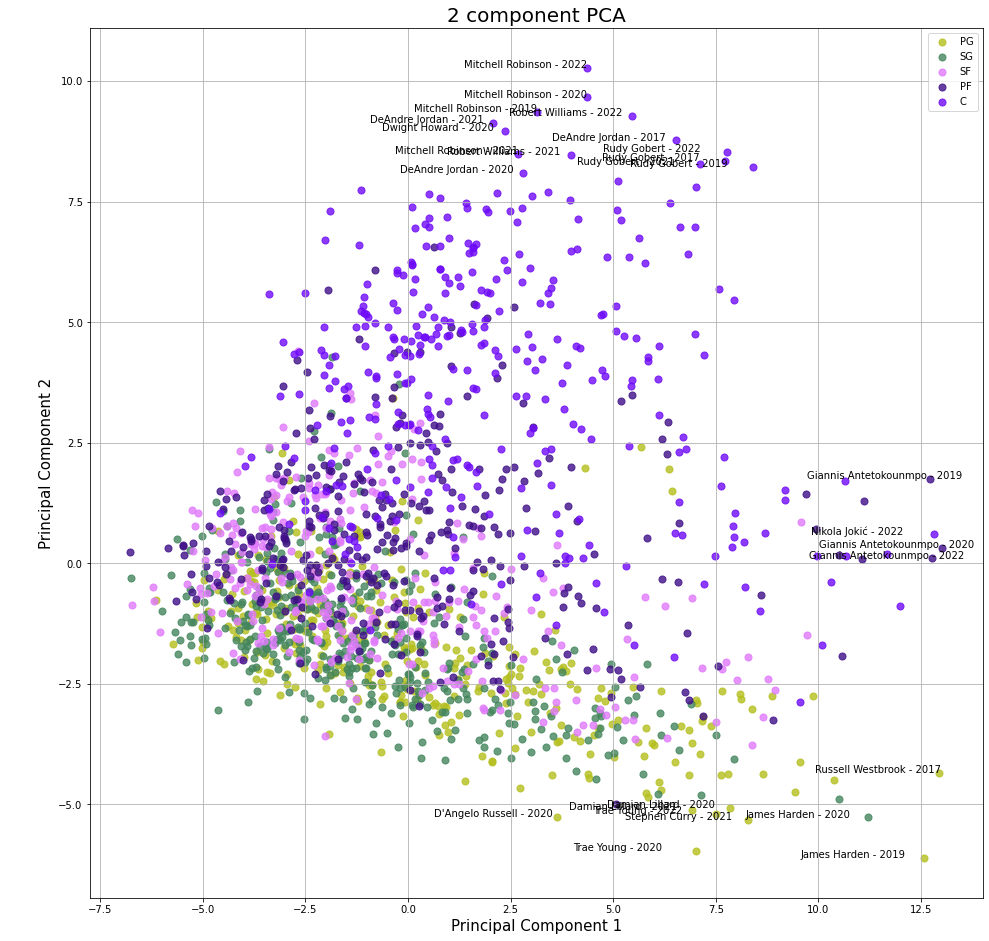

In [49]:
plot_pca(pca_df, 'Pos', ['PG', 'SG', 'SF', 'PF', 'C'], -5, -5, 12, 8)

## Run k-means clustering for the previous PCA

In [50]:
data = list(zip(pca_df["PC1"], pca_df["PC2"]))

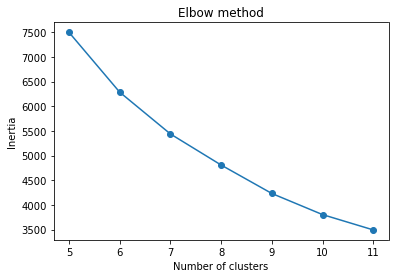

In [51]:
plot_elbow_method(data, range(5,12))

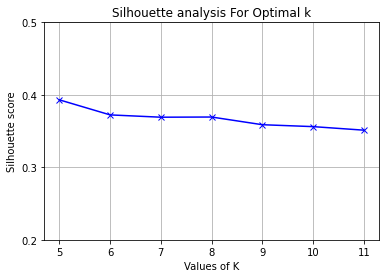

In [52]:
silhouette_avg = plot_silhouette_method(data, range(5,12))

In [53]:
CLUSTERS = np.argmax(silhouette_avg)+5

In [54]:
pca_df['Cluster'], cmap = run_kmeans(data, CLUSTERS)

## Plot K-means

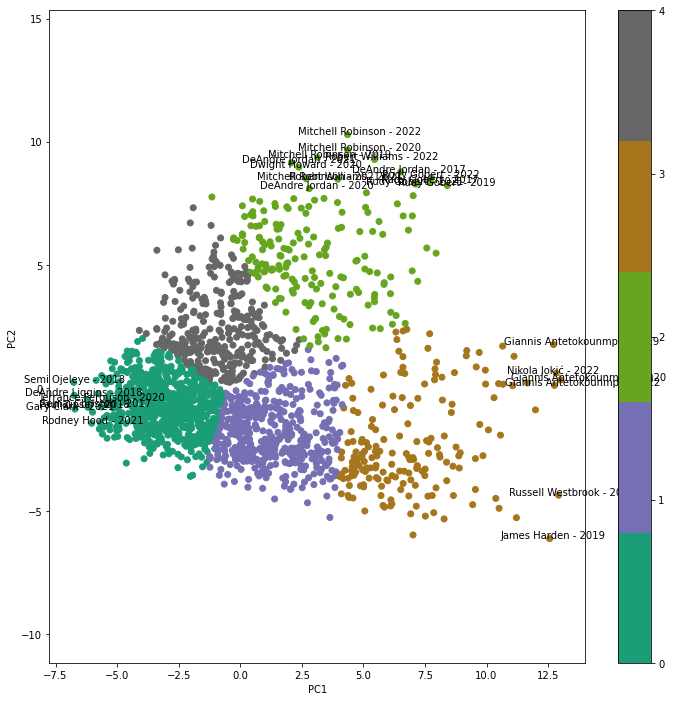

In [55]:
plot_kmeans(pca_df, cmap, CLUSTERS, -6, -7, 12, 8)

## Plot player distribution as cummulative bar charts

In [56]:
position_percentages = find_position_distribution(pca_df, CLUSTERS)

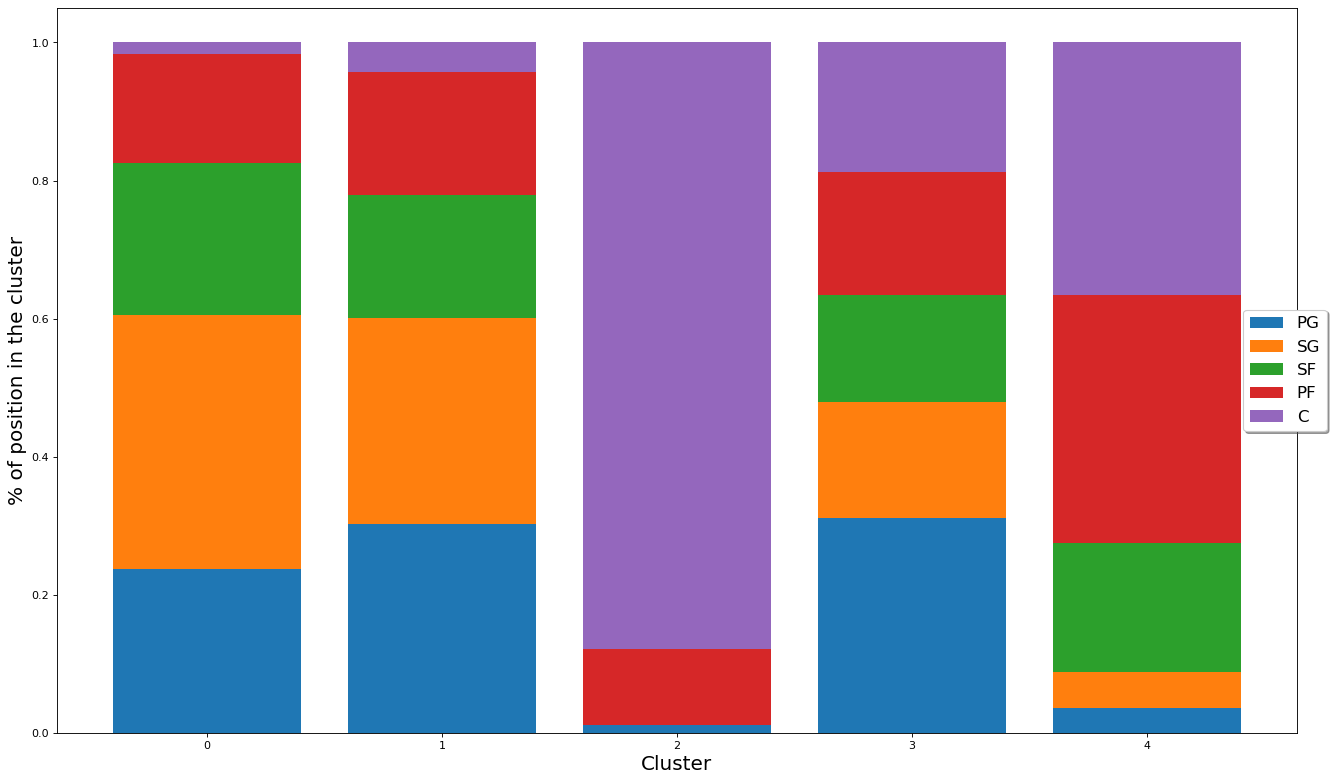

In [57]:
plot_position_distribution(position_percentages, CLUSTERS)

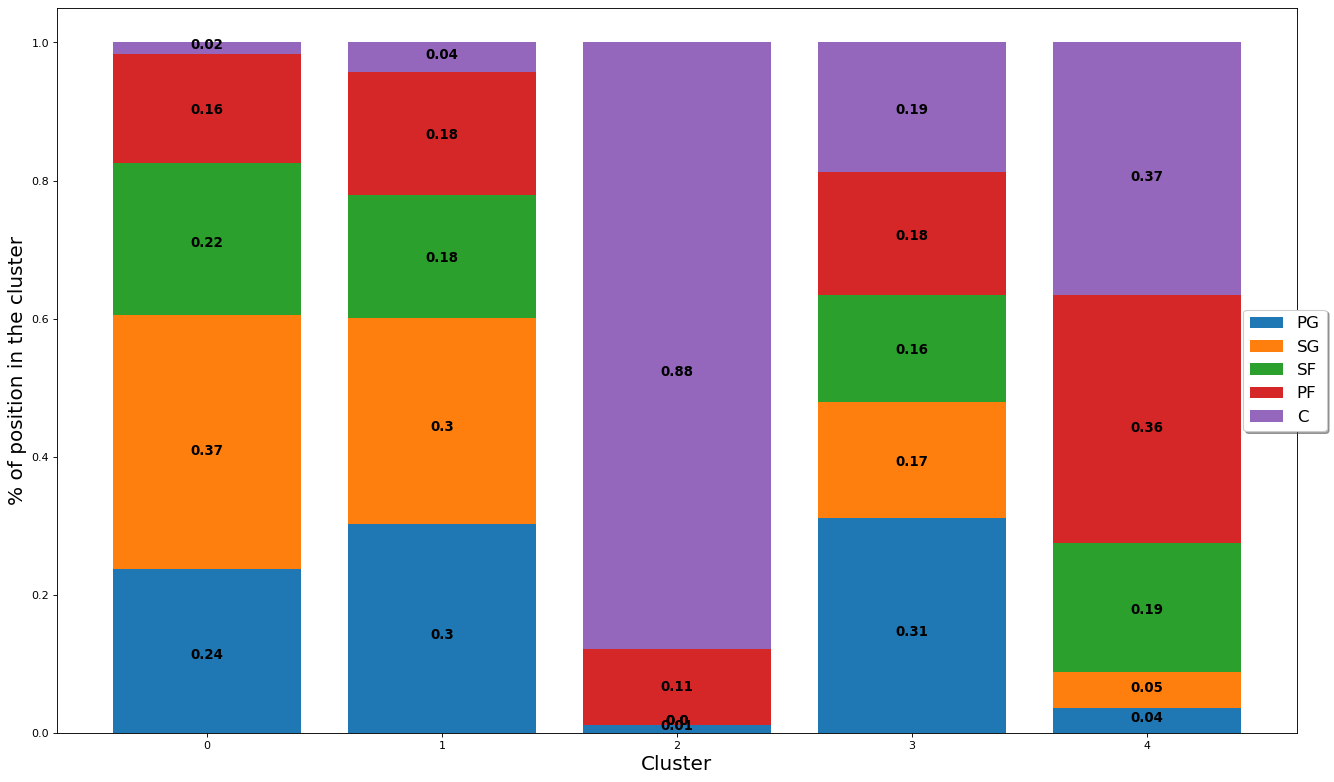

In [58]:
plot_position_distribution(position_percentages, CLUSTERS, True, "PlayerDistributionWithValues")